# 네트워크 추론

확률모형에서 일부 확률변수의 값이 주어졌을 때 다른 확률변수의 값이 얼마인지를 알아내는 것을 추론(inference)라고 한다. 

조건부 확률분포함수 $p(X_{\text{unknown}}|\{X\}_{\text{known}})$를 알면 일부 확률변수의 값 $\{X\}_{\text{known}}$이 주어졌을 때 다른 확률변수 $X_{\text{unknown}}$의 확률 $p(X_{\text{unknown}})$을 알 수 있으므로 추론은 조건부 확률분포함수 $p(X_{\text{unknown}}|\{X\}_{\text{known}})$를 알아내는 것과 같다.

앞에서 사용했던 예를 다시 들어보자. 확률변수 $A, B, C$가 각각 어떤 학생의 

* A: 건강 상태
* B: 공부 시간
* C: 시험 성적

을 나타낸 것이고 이 확률변수는 각각 $\{0, 1, 2\}$라는 값을 가질 수 있는데 하(0), 중(1), 상(2)의 상태를 나타낸다.  

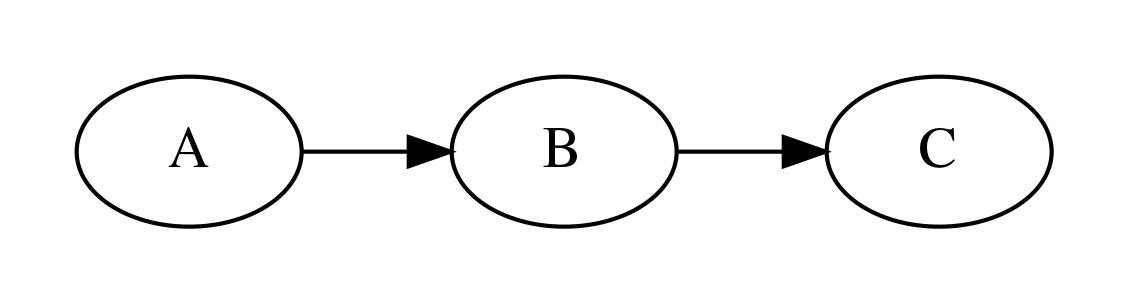

In [1]:
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel


P_A = TabularCPD('A', 3, [[0.1, 0.6, 0.3]])
P_B_I_A = TabularCPD('B', 3, 
    np.array([[0.6, 0.2, 0.2], [0.3, 0.5, 0.2], [0.1, 0.3, 0.6]]),
    evidence=['A'], evidence_card=[3])
P_C_I_B = TabularCPD('C', 3, 
    np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
    evidence=['B'], evidence_card=[3])
                     
model = BayesianModel([('A', 'B'), ('B', 'C')])
model.add_cpds(P_A, P_B_I_A, P_C_I_B)

d = to_pydot(model)
d.set_dpi(300)
d.set_margin(0.2)
d.set_rankdir("LR")
Image(d.create_png(), width=600)

이 그래프 확률모형을 기반으로 다음과 같은 문제를 풀어보자.

1. 이 학생의 시험 성적이 어떤 확률분포를 가질 것인가? 어떤 성적을 맞을 확률이 가장 높은가?
2. 이 학생의 건강 상태가 좋았다. 어떤 성적을 맞을 확률이 가장 높은가?
3. 이 학생의 공부 시간이 적었지만 시험 성적은 좋았다. 건강 상태가 어땠을까?

1번 문제는 무조건부 확률분포함수 $P(C)$를 찾는 것이다. 
2번 문제는 조건부 확률분포함수 $P(C|A=2)$를 찾는 것이고 3번 문제는 조건부 확률분포함수 $P(A|B=0, C=2)$를 찾는 문제이다.

베이지안 네트워크나 마코프 네트워크와 같은 그래프 확률모형에서 추론을 하려면

* 변수제거(variable elimination)
* 신뢰전파(belief propagation)

방법을 사용한다.

## 변수제거

위에서 예로 든 모형의 경우 결합확률분포는 다음과 같다.

$$ P(A, B, C) = P(A)P(B|A)P(C|B) $$

우선 특정한 확률변수의 무조건부 확률분포를 구하는 방법을 알아보자. 우선 $C$ 분포함수를 알 때 $B$의 분포함수는 다음처럼 구한다.

$$ 
\begin{eqnarray}
P(B=0) 
&=& \sum_A P(B=0|A)P(A) \\
&=& P(B=0|A=0)P(A=0) + P(B=0|A=1)P(A=1) + P(B=0|A=2)P(A=2) \\
\end{eqnarray}
$$

$B=1, B=2$인 경우에도 같은 방법으로 계산한다.

이번에는 $C$의 분포함수를 계산하자.

$$
\begin{eqnarray}
P(C) 
&=& \sum_{A, B} P(C|B)P(B|A)P(A) \\
\end{eqnarray}
$$

여기에서 $\sum_{A, B}$는 $A, B$가 가질 수 있는 모든 조합의 경우를 뜻한다.

$$ \sum_{A, B} = \sum_{A} \sum_{B} $$

따라서 

$$
\begin{eqnarray}
P(C=0) 
&=& P(C=0|B=0)P(B=0|A=0)P(A=0) + P(C=0|B=0)P(B=0|A=1)P(A=1) + P(C=0|B=0)P(B=0|A=2)P(A=2) + \\
& & P(C=0|B=1)P(B=1|A=0)P(A=0) + P(C=0|B=1)P(B=1|A=1)P(A=1) + P(C=0|B=1)P(B=1|A=2)P(A=2) + \\
& & P(C=0|B=2)P(B=2|A=0)P(A=0) + P(C=0|B=2)P(B=2|A=1)P(A=1) + P(C=0|B=2)P(B=2|A=2)P(A=2) \\
\end{eqnarray}
$$

와 같이 $P(C=0)$을 구할 수 있다. 이제 계산량을 줄이기 위해 같은 계산은 인수분해로 묶어보면 

$$
\begin{eqnarray}
P(C=0) 
&=& P(C=0|B=0) \big( P(B=0|A=0)P(A=0) + P(B=0|A=1)P(A=1) + P(B=0|A=2)P(A=2) \big) + \\
& & P(C=0|B=1) \big( P(B=1|A=0)P(A=0) + P(B=1|A=1)P(A=1) + P(B=1|A=2)P(A=2) \big) + \\
& & P(C=0|B=2) \big( P(B=2|A=0)P(A=0) + P(B=2|A=1)P(A=1) + P(B=2|A=2)P(A=2) \big) \\
&=& P(C=0|B=0) P(B=0) + \\
& & P(C=0|B=1) P(B=1) + \\
& & P(C=0|B=2) P(B=2) \\
\end{eqnarray}
$$

즉, 확률변수 $B$의 분포가 이미 계산된 상태라면 확률변수 $A$의 영향은 없어진다.

$$ P(C) = \sum_{B} P(C|B)P(B) $$

이런 식으로 값을 알고 있는 확률변수 혹은 무조건부 확률변수분포를 알고있는 확률변수부터 네트워크를 따라 차례대로 확률분포를 계산하는 방식을 변수제거(variable elimination) 방법이라고 한다. 

pgmpy에서는 `VariableElimination` 클래스를 사용하여 변수제거법을 적용할 수 있다. 생성자 인수로 네트워크 모형을 넣으며 `query` 메서드를 지원한다.

* `query(variable_list, evidence)`

`variable_list`는 확률분포를 구하려는 확률변수의 리스트이고 `evidence`는 알고 있는 확률변수 값의 딕셔너리이다.

아무런 조건이 없을 경우 시험성적의 분포는 다음과 같다. 보통의 성적을 받을 가능성이 가장 높다.

In [2]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
print(infer.query(["C"])["C"])

+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.2680 |
+-----+----------+
| C_1 |   0.3730 |
+-----+----------+
| C_2 |   0.3590 |
+-----+----------+


이는 A, B의 순서로 marginalize한 것과 같다.

$$ P(C) = \sum_A \sum_B P(A,B,C) = \sum_A \sum_B P(C|B)P(B|A)P(A) $$

In [3]:
P_B = (P_B_I_A * P_A).marginalize(["A"], inplace=False)
P_C = (P_C_I_B * P_B).marginalize(["B"], inplace=False)
print(P_C)

+-----+-------+
| C_0 | 0.268 |
+-----+-------+
| C_1 | 0.373 |
+-----+-------+
| C_2 | 0.359 |
+-----+-------+


만약 건강 상태가 좋았으면 `evidence={"A": 2}` 인수를 적용한다. 좋은 성적을 받을 가능성이 가장 높다.

In [4]:
print(infer.query(["C"], evidence={"A": 2})["C"])

+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.2400 |
+-----+----------+
| C_1 |   0.2400 |
+-----+----------+
| C_2 |   0.5200 |
+-----+----------+


이 결과는 $A=2$라는 확률분포에서 marginalize한 것과 같다.

In [5]:
P_A2 = TabularCPD('A', 3, [[0, 0, 1]])
P_B = (P_B_I_A * P_A2).marginalize(["A"], inplace=False)
P_C = (P_C_I_B * P_B).marginalize(["B"], inplace=False)
print(P_C)

+-----+------+
| C_0 | 0.24 |
+-----+------+
| C_1 | 0.24 |
+-----+------+
| C_2 | 0.52 |
+-----+------+


시험 성적과 공부 시간을 알고 있다면 다음처럼 건강 상태를 유추할 수도 있다.

In [6]:
print(infer.query(["A"], evidence={"B": 0, "C": 2})["A"])

+-----+----------+
| A   |   phi(A) |
+=====+==========+
| A_0 |   0.2500 |
+-----+----------+
| A_1 |   0.5000 |
+-----+----------+
| A_2 |   0.2500 |
+-----+----------+


B를 알고 있는 경우 A와 C는 서로 독립이다. 즉, 공부시간을 알고 있으으면 시험성적과 관계없이 건강상태를 유추할 수 있다.

In [7]:
print(infer.query(["A"], evidence={"B": 0})["A"])

+-----+----------+
| A   |   phi(A) |
+=====+==========+
| A_0 |   0.2500 |
+-----+----------+
| A_1 |   0.5000 |
+-----+----------+
| A_2 |   0.2500 |
+-----+----------+


이 추론은 조건부확률 $P(A|B)$를 구하는 것과 같다.

$$ P(A|B) = P(B|A)P(A)/P(B) $$

$P(B)$는 동일하므로 무시할 수 있다.

$$ P(A|B) \propto P(B|A)P(A) $$

In [8]:
print(P_B_I_A * P_A)

+-----+----------------------+------+------+
| A   | A_0                  | A_1  | A_2  |
+-----+----------------------+------+------+
| B_0 | 0.06                 | 0.12 | 0.06 |
+-----+----------------------+------+------+
| B_1 | 0.03                 | 0.3  | 0.06 |
+-----+----------------------+------+------+
| B_2 | 0.010000000000000002 | 0.18 | 0.18 |
+-----+----------------------+------+------+


특정한 값에 대한 조건 확률을 구하기 위해 factor로 바꾼 뒤 reduce 메소스들 수행한다.

In [9]:
print((P_B_I_A * P_A).to_factor().reduce([("B", 0)], inplace=False).normalize(inplace=False))

+-----+----------+
| A   |   phi(A) |
+=====+==========+
| A_0 |   0.2500 |
+-----+----------+
| A_1 |   0.5000 |
+-----+----------+
| A_2 |   0.2500 |
+-----+----------+


## 몬티 홀 문제

베이지안 네트워크를 사용하여 몬티 홀 문제를 풀어보자. 0, 1, 2로 표시된 3개의 문 중에서 자동차(car)가 있는 문을 나타내는 확률변수는 C, 참가자(player)가 고른 문은 P, 진행자(host)가 여는 문을 H라고 하자.

자동차가 어떤 문에 있는가와 참가자가 어떤 문을 고르는지는 모두 같은 확률을 가진다.

In [10]:
from pgmpy.factors.discrete import TabularCPD

P_C = TabularCPD('C', 3, [[0.33, 0.33, 0.33]])
print(P_C)

+-----+------+
| C_0 | 0.33 |
+-----+------+
| C_1 | 0.33 |
+-----+------+
| C_2 | 0.33 |
+-----+------+


In [11]:
P_P = TabularCPD('P', 3, [[0.33, 0.33, 0.33]])
print(P_P)

+-----+------+
| P_0 | 0.33 |
+-----+------+
| P_1 | 0.33 |
+-----+------+
| P_2 | 0.33 |
+-----+------+


하지만 진행자가 여는 문은 자동차의 위치와 참가자의 선택에 따라 달라진다. 진행자는 항상 참가자가 고르지 않은 문 중에서 자동차가 없는 문을 연다.

In [12]:
P_H_I_CP = TabularCPD('H', 3, [[0,   0, 0, 0, 0.5, 1, 0, 1, 0.5], 
                               [0.5, 0, 1, 0,   0, 0, 1, 0, 0.5], 
                               [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0  ]],
                      evidence=['C', 'P'], evidence_card=[3, 3])
print(P_H_I_CP)

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| C   | C_0 | C_0 | C_0 | C_1 | C_1 | C_1 | C_2 | C_2 | C_2 |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| P   | P_0 | P_1 | P_2 | P_0 | P_1 | P_2 | P_0 | P_1 | P_2 |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| H_0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.5 | 1.0 | 0.0 | 1.0 | 0.5 |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| H_1 | 0.5 | 0.0 | 1.0 | 0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.5 |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| H_2 | 0.5 | 1.0 | 0.0 | 1.0 | 0.5 | 0.0 | 0.0 | 0.0 | 0.0 |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+


베이지안 네트워크로 확률모형을 만든다. 진행자의 선택 H는 자동차 위치 C와 참가자 선택 P에 모두 영향을 받는 머리-머리 결합이다.

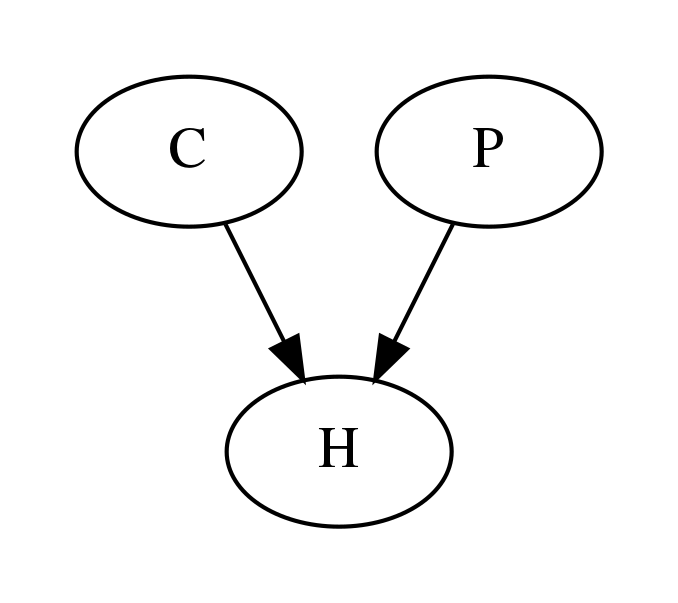

In [13]:
from pgmpy.models import BayesianModel
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

model_monty = BayesianModel([('C', 'H'), ('P', 'H')])
model_monty.add_cpds(P_C, P_P, P_H_I_CP)

d = to_pydot(model_monty)
d.set_dpi(300)
d.set_margin(0.2)
Image(d.create_png(), width=400)

변수제거 방법을 사용하여 이 문제를 푼다.

In [14]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model_monty)

만약 참가자가 0번 문을 선택하면 진행자는 1번 혹은 2번 문을 연다.

In [15]:
posteriors = infer.query(['C', 'H'], evidence={'P': 0})
print(posteriors['H'])

+-----+----------+
| H   |   phi(H) |
+=====+==========+
| H_0 |   0.0000 |
+-----+----------+
| H_1 |   0.5000 |
+-----+----------+
| H_2 |   0.5000 |
+-----+----------+


참가자가 0번 문을 선택하고 진행자가 1번 문을 열면 차가 2번 문에 있을 확률이 0번 문에 있을 확률의 2배이다.

In [16]:
posterior_c = infer.query(['C'], evidence={'P': 0, 'H': 1})
print(posterior_c['C'])

+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.3333 |
+-----+----------+
| C_1 |   0.0000 |
+-----+----------+
| C_2 |   0.6667 |
+-----+----------+


같은 상황에서 진행자가 2번 문을 열면 차가 1번 문에 있을 확률이 0번 문에 있을 확률의 2배이다. 따라서 참가자는 항상 선택을 바꾸는 것이 좋다.

In [17]:
posterior_c = infer.query(['C'], evidence={'P': 1, 'H': 2})
print(posterior_c['C'])

+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.6667 |
+-----+----------+
| C_1 |   0.3333 |
+-----+----------+
| C_2 |   0.0000 |
+-----+----------+


## 신뢰전파

신뢰전파(belief propagation) 방법은 메시지 전달(message passin) 방법이라고도 한다. 여기에서는 선형 체인(linear chain) 형태의 마코프 네트워크를 예로 들어 설명하겠지만 일반적인 형태의 네트워크에서도 성립한다.

$X_1, \ldots, X_N$의 $N$개 확률변수가 선형사슬로 연결된 마코프 네트워크에서 결합확률분포는

$$
p(X_1, \ldots, X_N) = \dfrac{1}{Z}\psi(X_1, X_2) \psi(X_2, X_3) \cdots \psi(X_{N-1}, X_{N}) 
$$

이다. 사슬 중간에 있는 $X_n$의 확률분포를 알아내려면 전체확률의 법칙을 사용하여 $X_n$을 제외한 나머지 확률변수들이 가질 수 있는 모든 경우의 확률을 더한다.

$$
\begin{eqnarray}
p(X_n) 
&=& \sum_{X_1} \cdots \sum_{X_{n-1}} \sum_{X_{n+1}} \cdots \sum_{X_N} p(X_1, \ldots, X_N) \\
&=& \dfrac{1}{Z} \sum_{X_1} \cdots \sum_{X_{n-1}} \sum_{X_{n+1}} \cdots \sum_{X_N} \psi(X_1, X_2) \psi(X_2, X_3) \cdots \psi(X_{N-1}, X_{N}) \\
\end{eqnarray}
$$

이 수식을 정리하면 다음처럼 쓸 수 있다.

$$
p(X_n) = \dfrac{1}{Z} \\
\underbrace{\left(\sum_{X_{n-1}} \psi(X_{n-1}, X_n) \left( \sum_{X_{n-2}} \psi(X_{n-2}, X_{n-1}) \cdots \left( \sum_{X_1} \psi(X_1, X_2) \right) \right)\right)}_{\mu_{\alpha}(X_n)} \\
\underbrace{\left( \sum_{X_{n+1}} \psi(X_{n}, X_{n+1}) \left( \sum_{X_{n+2}} \psi(X_{n+1}, X_{n+2}) \cdots \left( \sum_{X_N} \psi(X_{N-1}, X_{N}) \right) \right) \right)}_{\mu_{\beta}(X_n)} \\
= \dfrac{1}{Z} \mu_{\alpha}(X_n) \mu_{\beta}(X_n)
$$

이 식에서 $\mu_{\alpha}(X_n)$와 $\mu_{\beta}(X_n)$를 $X_n$에 도달하는 좌측, 우측 메시지(message) 함수라고 한다.

메시지 함수는 재귀적으로 계산할 수 있다.

$$
\begin{eqnarray}
\mu_{\alpha}(X_n)
&=& \sum_{X_{n-1}} \psi(X_{n-1}, X_n) \left( \sum_{X_{n-2}} \psi(X_{n-2}, X_{n-1}) \cdots \left( \sum_{X_1} \psi(X_1, X_2) \right) \right) \\
&=& \sum_{X_{n-1}} \psi(X_{n-1}, X_n) \mu_{\alpha}(X_{n-1}) \\
\mu_{\alpha}(X_2) &=& \sum_{X_1} \psi(X_1, X_2)
\end{eqnarray}
$$

<img src="https://datascienceschool.net/upfiles/2f773a48123b461fa29f82f69c73d699.png">

건강 상태 및 시험 성적과 관련된 예제를 마코프 네트워크로 변형하여 신뢰전파를 적용해보자.

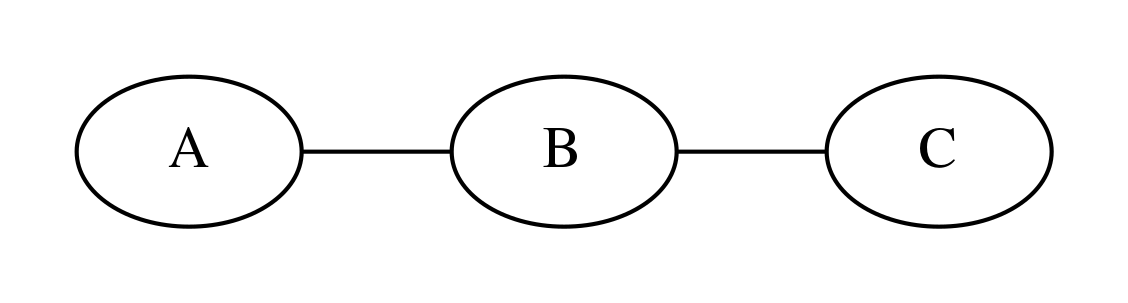

In [18]:
model2 = model.to_markov_model()

d = to_pydot(model2)
d.set_dpi(300)
d.set_margin(0.2)
d.set_rankdir("LR")
Image(d.create_png(), width=400)

pgmpy에서는 `BeliefPropagation` 클래스를 사용하여 신뢰전파법을 적용할 수 있다. 사용법은 `VariableElimination`과 같다.

In [19]:
from pgmpy.inference import BeliefPropagation
infer = BeliefPropagation(model)
print(infer.query(["C"])["C"])

+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.2680 |
+-----+----------+
| C_1 |   0.3730 |
+-----+----------+
| C_2 |   0.3590 |
+-----+----------+


In [20]:
print(infer.query(["C"], evidence={"A": 2})["C"])

+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.2400 |
+-----+----------+
| C_1 |   0.2400 |
+-----+----------+
| C_2 |   0.5200 |
+-----+----------+


In [21]:
print(infer.query(["A"], evidence={"B": 0, "C": 2})["A"])

+-----+----------+
| A   |   phi(A) |
+=====+==========+
| A_0 |   0.2500 |
+-----+----------+
| A_1 |   0.5000 |
+-----+----------+
| A_2 |   0.2500 |
+-----+----------+
